# Process dataset

In [10]:
import os
import json
import datasets
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
data_path = '/Users/dhruvd/nemo_customiser_k8_utils/data'
dataset = datasets.load_dataset(data_path)

Generating train split: 153511 examples [00:00, 847775.33 examples/s]


In [4]:
# Assuming 'label' is the column you want to stratify by
stratify_column_name = "label"

# Cast the column to ClassLabel
dataset = dataset.class_encode_column(stratify_column_name)

Casting to class labels: 100%|██████████| 153511/153511 [00:00<00:00, 1206459.59 examples/s]


In [5]:
DATASET_PROMPT_FORMAT = """
You are a helpful AI assistant that analyses financial news headlines and identifies what event type is described.
You will classify event types into one of the following categories (in square brackets)

- [Analyst Rating]: An entity such as a bank, asset manager, etc. gives a classification/rating/downgrade/upgrade/opinion to an asset.
                    If there is no specified analyst and company given, it's not Analyst Rating and should be classified as OTHER.
- [Price Targets]: A mention of a price target (PT) is given by an entity such as bank, asset manager, etc.
                   This takes priority over any other class, so if a price target is present use this class!
- [Earnings]: Reports of quarterly, monthly, etc. concrete values of revenue, ESP, etc. Percentage fluctations.
              Expected values are not Earnings and should be Guidance instead!
- [Labour Issues]: Mentions of layoffs, union action, strikes, rising cost of labour, bonuses for execs, etc. Important personal change, e.g. CEO, CFO, VPs, etc.
- [Mergers and Acquisitions]: Whenever merging or acquisition of entities, not just companies, is mentioned.
                              Things like partnerships do not belong to this class! Takes priority over other classes.
- [Dividends]: Mentions of dividend performance, dividend per share, decisions not to issue dividends, etc.
- [Regulatory]: Mentions corporate position focused on environmental affairs, government regulation, international treaties, geopolitics, debt repayment, licenses, patents, etc.
                Any executive decisions taken by the government are Regulatory. Takes priority over other classes.
- [Stock price movement]: Includes pricing of public offerings, daily, monthly and yearly movements, highs and lows, options trade and alerts, etc.
                          Only relevant when a specific entity/industry or set of entities/industries mentioned.
                          Quantities such as sales, are not stock price movements. Stock splits do not count as stock movements.
                          Takes priority over Earnings, Stock Price Movement, Credit Ratings
- [Credit Ratings]: Adjustments of company's borrowing capacity, changes in debt values, changes in ratings, etc.
- [Products-Services]: Mentions of a company's particular product, forward-looking product directions, disruption, government and private contracts, etc.
                       Any sort of delay regarding a product roll-out, etc.
- [Product Approval]: Mentions FDA approvals, environmental approvals, acceptance for review. Any time an entity approves the rollout of a corporations product.
- [Guidance]: Forward looking statements issued by the company's themselves regarding Revenue, EPS, potential sales going up/down, number of contracts, etc.
              Similar talk to earnings but about projections rather than realised.
              
If the headline doesn't match any of the classes, classify it as OTHER.
If there are no events at all described in the headline, classify it as NO EVENT.
ATTENTION:
  - Only assign a category if the headline meets all the criteria listed for that category. Otherwise use OTHER
  - Encourage precise matching rather than assigning categories based on partial or superficial similarities
  - OTHER is the default category for when there is an event but there is doubt about which type
  - If there are no events mentioned, use NO EVENT

A few examples:

1. Cornerstone OnDemand Higher as Barclays Upgraded to Overweight -> [Analyst Rating]
2. HC Wainwright & Co. Maintains Buy on Balchem, Lowers Price Target to $104 -> [Price Targets]
3. Sina Reports Q4 Adj. EPS $0.24 vs $0.18 Est., Sales $211.1M vs $207.6M Est.; Sees FY15 Sales $800M-$900M vs $884.6M Est. -> [Earnings]
4. Delta To Buy Out Employees, Offer Early Retirement (DAL) -> [Labour Issues]
5. Constant Contact Announces Deal to Be Purchased by Endurance Int'l at $32/Share -> [Mergers and Acquisitions]
6. Ameriprise Financial Announces 12% Qtr. Dividend Increase to $0.58/Share -> [Dividends]
7. Ultratech Achieves ISO 9001 and 14001 Certification for Singapore Operations and Recertification for U.S. Facility  -> [Regulatory]
8. Mid-Afternoon Market Update: Dow Up Over 200 Points; Lakeland Industries Shares Spike Higher -> [Stock price movement]
9. Moody's Affirms Ratings on Nokia; Outlook Revised from Negative to Developing -> [Credit Ratings]
10. NOVAVAX Awarded HHS-BARDA Contract Valued at up to $179 Million  -> [Products-Services]
11. Sanofi's Genzyme Announces Lemtrada Resubmission Accepted for Review by FDA  -> [Product Approval]
12. Dot Hill Systems Announces Re-alignment of Software Development Initiatives; Sees Q4 EPS of $(0.02)-(0.03) vs $0.03-(0.03) Prior  -> [Guidance]
13. Kopin Chairman Fan Buys 116,400 Shares @$2.83/Share -Form 4 -> [OTHER]

Given the following headline:

### START HEADLINE ###

{headline}

### END HEADLINE ###

What event type best classifies it? Answer only with your predicted class and give it inside double square brackets, like [[class]]
"""

In [6]:
train_ratio = 0.8
val_ratio = 0.1
seed = 42
test_ratio = 1 - train_ratio - val_ratio
save_splits = {}
dataset = dataset.get('train')
# Get the class labels
class_labels = dataset.features['label']
split_dataset = dataset.train_test_split(test_size=val_ratio + test_ratio, seed=seed, stratify_by_column='label')
split_dataset2 = split_dataset['test'].train_test_split(
    test_size=test_ratio / (val_ratio + test_ratio), seed=seed,stratify_by_column='label')
save_splits['training'] = split_dataset['train']
save_splits['validation'] = split_dataset2['train']
save_splits['test'] = split_dataset2['test']

print("len training: ", len(save_splits['training']))
print("len validation: ", len(save_splits['validation']))
print("len test: ", len(save_splits['test']))

len training:  122808
len validation:  15351
len test:  15352


In [7]:
dataset_root = "data"
os.makedirs(dataset_root, exist_ok=True)

for split_name, dataset in save_splits.items():
    split_root = os.path.join(dataset_root, split_name)
    os.makedirs(split_root, exist_ok=True)
    
    file_counter = 0
    line_counter = 0
    max_lines_per_file = 10000
    
    output_file = os.path.join(split_root, f"{split_name}_{file_counter}.jsonl")
    print(f"Processing {split_name} to {output_file}")
    
    f = open(output_file, "w", encoding="utf-8")
    
    for example in dataset:
        if line_counter >= max_lines_per_file:
            f.close()
            file_counter += 1
            line_counter = 0
            output_file = os.path.join(split_root, f"{split_name}_{file_counter}.jsonl")
            print(f"Creating new file: {output_file}")
            f = open(output_file, "w", encoding="utf-8")
        
        if DATASET_PROMPT_FORMAT != "":
            _input = DATASET_PROMPT_FORMAT.format(headline=example["headline"])
            _output = class_labels.int2str(example["label"])
        f.write(json.dumps({"prompt": _input, "completion": _output}) + "\n")
        line_counter += 1
    
    f.close()
    print(f"{split_name} split saved with {file_counter + 1} file(s)")

Processing training to data/training/training_0.jsonl
Creating new file: data/training/training_1.jsonl
Creating new file: data/training/training_2.jsonl
Creating new file: data/training/training_3.jsonl
Creating new file: data/training/training_4.jsonl
Creating new file: data/training/training_5.jsonl
Creating new file: data/training/training_6.jsonl
Creating new file: data/training/training_7.jsonl
Creating new file: data/training/training_8.jsonl
Creating new file: data/training/training_9.jsonl
Creating new file: data/training/training_10.jsonl
Creating new file: data/training/training_11.jsonl
Creating new file: data/training/training_12.jsonl
training split saved with 13 file(s)
Processing validation to data/validation/validation_0.jsonl
Creating new file: data/validation/validation_1.jsonl
validation split saved with 2 file(s)
Processing test to data/test/test_0.jsonl
Creating new file: data/test/test_1.jsonl
test split saved with 2 file(s)


In [ ]:
# Prepare data for all splits
distribution_data = {}
for split, data in save_splits.items():
    df = data.to_pandas()
    df['label'] = df['label'].apply(lambda x: class_labels.int2str(x))
    df_distribution = (df.groupby('label').size()/df.shape[0])*100
    distribution_data[split] = df_distribution

# Convert to DataFrame for easier plotting
combined_df = pd.DataFrame(distribution_data).fillna(0)
combined_df.index = combined_df.index.str.replace('[[','').str.replace(']]','')

In [29]:
combined_df


,training,validation,test
label,,,
analyst rating,11.038369,11.035112,11.040907
credit ratings,0.525210,0.527653,0.521105
dividends,1.428246,1.426617,1.426524
earnings,13.021139,13.021953,13.021105
guidance,6.462934,6.462120,6.461699
labour issues,2.371181,2.371181,2.371027
mergers and acquisitions,6.053352,6.051723,6.051329
no event,5.701583,5.706469,5.699583
other,10.351117,10.351117,10.350443


<Figure size 2000x1500 with 0 Axes>

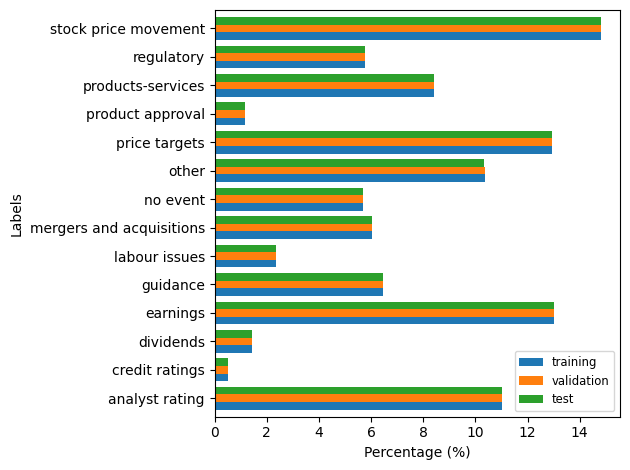

In [42]:
# Plot with labels on y-axis and percentage on x-axis, grouped by split
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
combined_df.plot(kind='barh',
                #  title='Label Distribution Across All Splits',
                 xlabel='Percentage (%)',
                 ylabel='Labels',
                 rot=0,
                 width=0.8,
                 )
plt.legend(loc='lower right', fontsize='small')
# plt.legend(title='Dataset Split', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('label_distribution.pdf',bbox_inches='tight')
plt.show()

# Add the datasets to NeMo Microservices

In [7]:
import os
import json
import random
import requests
from openai import OpenAI
from nemo_microservices import NeMoMicroservices

In [8]:
from config import *

# Initialize NeMo Microservices SDK client
nemo_client = NeMoMicroservices(
    base_url=NEMO_URL,
    inference_base_url=NIM_URL,
)

In [9]:
nemo_client.projects.list()

SyncDefaultPagination[Project](object='list', data=[], sort='created_at', pagination=DefaultPaginationPagination(current_page_size=0, page=1, page_size=10, total_pages=0, total_results=0))

In [10]:
print(f"Data Store endpoint: {NDS_URL}")
print(f"Entity Store, Customizer, Evaluator endpoint: {NEMO_URL}")
print(f"NIM endpoint: {NIM_URL}")
print(f"Namespace: {NMS_NAMESPACE}")
print(f"Base Model for Customization: {BASE_MODEL}@{BASE_MODEL_VERSION}")

Data Store endpoint: http://data-store.test
Entity Store, Customizer, Evaluator endpoint: http://nemo.test
NIM endpoint: http://nim.test
Namespace: lora-tutorial-ns
Base Model for Customization: meta/llama-3.1-8b-instruct@v1.0.0+A100


In [11]:
# Path where data preparation notebook saved finetuning and evaluation data
DATA_ROOT = os.path.join(os.getcwd(), "data")
TRAINING_DATA_ROOT = os.path.join(DATA_ROOT, "training")
VALIDATION_DATA_ROOT = os.path.join(DATA_ROOT, "validation")
TEST_DATA_ROOT = os.path.join(DATA_ROOT, "test")

# Sanity checks
train_fp = f"{TRAINING_DATA_ROOT}/training_0.jsonl"
assert os.path.exists(train_fp), f"The training data at '{train_fp}' does not exist. Please ensure that the data was prepared successfully."

val_fp = f"{VALIDATION_DATA_ROOT}/validation_0.jsonl"
assert os.path.exists(val_fp), f"The validation data at '{val_fp}' does not exist. Please ensure that the data was prepared successfully."

test_fp = f"{TEST_DATA_ROOT}/test_0.jsonl"
assert os.path.exists(test_fp), f"The test data at '{test_fp}' does not exist. Please ensure that the data was prepared successfully."

In [12]:
def create_namespaces(nemo_client, ds_host, namespace):
    # Create namespace in Entity Store
    try:
        namespace_obj = nemo_client.namespaces.create(id=namespace)
        print(f"Created namespace in Entity Store: {namespace_obj.id}")
    except Exception as e:
        # Handle if namespace already exists
        if "409" in str(e) or "422" in str(e):
            print(f"Namespace {namespace} already exists in Entity Store")
        else:
            raise e

    # Create namespace in Data Store (still using requests as SDK doesn't cover Data Store)
    nds_url = f"{ds_host}/v1/datastore/namespaces"
    resp = requests.post(nds_url, data={"namespace": namespace})
    assert resp.status_code in (200, 201, 409, 422), \
        f"Unexpected response from Data Store during namespace creation: {resp.status_code}"
    print(f"Data Store namespace creation response: {resp}")

In [13]:
create_namespaces(nemo_client=nemo_client, ds_host=NDS_URL, namespace=NMS_NAMESPACE)

Created namespace in Entity Store: lora-tutorial-ns
Data Store namespace creation response: <Response [201]>


In [14]:
# Verify Namespace in Data Store (using requests as SDK doesn't cover Data Store)
response = requests.get(f"{NDS_URL}/v1/datastore/namespaces/{NMS_NAMESPACE}")
print(f"Data Store - Status Code: {response.status_code}\nResponse JSON: {response.json()}")

# Verify Namespace in Entity Store
namespace_obj = nemo_client.namespaces.retrieve(namespace_id=NMS_NAMESPACE)
print(f"\nEntity Store - Namespace: {namespace_obj.id}")
print(f"Created at: {namespace_obj.created_at}")
print(f"Description: {namespace_obj.description}")
print(f"Project: {namespace_obj.project}")

Data Store - Status Code: 201
Response JSON: {'namespace': 'lora-tutorial-ns', 'created_at': '2025-09-03T13:46:19Z', 'updated_at': '2025-09-03T13:46:19Z'}

Entity Store - Namespace: lora-tutorial-ns
Created at: 2025-09-03 13:46:19.890721
Description: None
Project: None


In [15]:
repo_id = f"{NMS_NAMESPACE}/{DATASET_NAME}"

In [16]:
from huggingface_hub import HfApi

hf_api = HfApi(endpoint=f"{NDS_URL}/v1/hf", token="")

# Create repo
hf_api.create_repo(
    repo_id=repo_id,
    repo_type='dataset',
)

RepoUrl('datasets/lora-tutorial-ns/news-lora-dataset', endpoint='http://data-store.test/v1/hf', repo_type='dataset', repo_id='lora-tutorial-ns/news-lora-dataset')

In [23]:
hf_api.upload_folder(folder_path=TRAINING_DATA_ROOT,
    path_in_repo="training",
    repo_id=repo_id,
    repo_type='dataset',
)

hf_api.upload_folder(folder_path=VALIDATION_DATA_ROOT,
    path_in_repo="validation",
    repo_id=repo_id,
    repo_type='dataset',
)

hf_api.upload_folder(folder_path=TEST_DATA_ROOT,
    path_in_repo="testing",
    repo_id=repo_id,
    repo_type='dataset',
)

training_0.jsonl:   0%|          | 0.00/52.5M [00:00<?, ?B/s]









training_0.jsonl:  21%|██▏       | 11.3M/52.5M [00:00<00:00, 113MB/s]


training_12.jsonl: 100%|██████████| 14.7M/14.7M [00:00<00:00, 116MB/s]




training_0.jsonl:  47%|████▋     | 24.8M/52.5M [00:00<00:00, 126MB/s]






training_0.jsonl:  72%|███████▏  | 37.6M/52.5M [00:00<00:00, 127MB/s]






training_10.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 114MB/s]
training_11.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 113MB/s]

training_1.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 109MB/s]
training_0.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 108MB/s]
training_4.jsonl:   0%|          | 0.00/52.5M [00:00<?, ?B/s]




training_2.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 145MB/s]





training_4.jsonl:  21%|██        | 11.0M/52.5M [00:00<00:00, 110MB/s]






training_4.jsonl:  46%|████▌     | 24.2M/52.5M [00:00<00:00, 123MB/s]






training_4.jsonl:  73%|███████▎  | 38.2M/52.5M [00:00<

CommitInfo(commit_url='', commit_message='Upload folder using huggingface_hub', commit_description='', oid='829012eda9a3cc3f69e23e0336b9f40cb03c9e39', pr_url=None, repo_url=RepoUrl('', endpoint='https://huggingface.co', repo_type='model', repo_id=''), pr_revision=None, pr_num=None)

In [19]:
 # Create dataset
dataset = nemo_client.datasets.create(
    name=DATASET_NAME,
    namespace=NMS_NAMESPACE,
    description="News Dataset for FSI Blueprint",
    files_url=f"hf://datasets/{NMS_NAMESPACE}/{DATASET_NAME}",
    project="tool_calling",
    
)
print(f"Created dataset: {dataset.namespace}/{dataset.name}")
dataset

Created dataset: lora-tutorial-ns/news-lora-dataset


Dataset(files_url='hf://datasets/lora-tutorial-ns/news-lora-dataset', id='dataset-Lkw5n7ZSow1oURgJmb2NWb', created_at=datetime.datetime(2025, 9, 3, 13, 51, 14, 815892), custom_fields={}, description='News Dataset for FSI Blueprint', format=None, hf_endpoint=None, limit=None, name='news-lora-dataset', namespace='lora-tutorial-ns', project='tool_calling', split=None, updated_at=datetime.datetime(2025, 9, 3, 13, 51, 14, 815894))

In [20]:
# Sanity check to validate dataset
dataset_obj = nemo_client.datasets.retrieve(namespace=NMS_NAMESPACE, dataset_name=DATASET_NAME)

print("Files URL:", dataset_obj.files_url)
assert dataset_obj.files_url == f"hf://datasets/{repo_id}"

Files URL: hf://datasets/lora-tutorial-ns/news-lora-dataset


# Optional - Create subsets of train with smaller sizes

In [21]:
# Create per-subset canonical datasets for NeMo Microservices
import os, json
from datetime import datetime

SUBSET_SIZES = [5_000, 10_000, 20_000, 50_000, 100_000, "all"]
SEED = 42
OUT_DIR = os.path.join(DATA_ROOT, "subsets")
os.makedirs(OUT_DIR, exist_ok=True)

def _write_jsonl(ds, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        for ex in ds:
            prompt = DATASET_PROMPT_FORMAT.format(headline=ex["headline"]) if DATASET_PROMPT_FORMAT else ex["headline"]
            completion = class_labels.int2str(ex["label"])
            f.write(json.dumps({"prompt": prompt, "completion": completion}) + "\n")

def _write_jsonl_chunked(ds, output_dir, filename_prefix, max_lines_per_file=10000):
    """Write dataset to JSONL files with chunking, similar to cell 7"""
    os.makedirs(output_dir, exist_ok=True)
    
    file_counter = 0
    line_counter = 0
    f = None
    
    for ex in ds:
        if f is None or line_counter >= max_lines_per_file:
            if f is not None:
                f.close()
            output_file = os.path.join(output_dir, f"{filename_prefix}_{file_counter}.jsonl")
            f = open(output_file, "w", encoding="utf-8")
            file_counter += 1
            line_counter = 0
        
        prompt = DATASET_PROMPT_FORMAT.format(headline=ex["headline"]) if DATASET_PROMPT_FORMAT else ex["headline"]
        completion = class_labels.int2str(ex["label"])
        f.write(json.dumps({"prompt": prompt, "completion": completion}) + "\n")
        line_counter += 1
    
    if f is not None:
        f.close()

train_full = save_splits["training"]
val_src = save_splits["validation"]
test_src = save_splits["test"]

def _subset_for_size(size):
    if size == "all" or (isinstance(size, int) and size >= len(train_full)):
        return train_full, "all", len(train_full)
    sub = train_full.train_test_split(train_size=size, seed=SEED, stratify_by_column="label")["train"]
    return sub, f"{size//1000}k", size

created = []
for size in SUBSET_SIZES:
    sub, tag, n = _subset_for_size(size)

    # Local directories for this subset
    subset_dir = os.path.join(OUT_DIR, f"train_{tag}")
    train_dir = os.path.join(subset_dir, "training")
    val_dir = os.path.join(subset_dir, "validation") 
    test_dir = os.path.join(subset_dir, "test")

    # Write chunked JSONL files
    _write_jsonl_chunked(sub, train_dir, "training")
    _write_jsonl_chunked(val_src, val_dir, "validation")
    _write_jsonl_chunked(test_src, test_dir, "test")

    # HF dataset repo name and NeMo Dataset name per subset
    subset_ds_name = f"{DATASET_NAME}-train-{tag}"
    subset_repo_id = f"{NMS_NAMESPACE}/{subset_ds_name}"
    files_url = f"hf://datasets/{subset_repo_id}"

    # Create (or reuse) HF dataset repo and upload folders
    try:
        hf_api.create_repo(repo_id=subset_repo_id, repo_type="dataset")
    except Exception as e:
        if "Repository already exists" not in str(e):
            pass

    hf_api.upload_folder(folder_path=train_dir, path_in_repo="training", repo_id=subset_repo_id, repo_type='dataset')
    hf_api.upload_folder(folder_path=val_dir, path_in_repo="validation", repo_id=subset_repo_id, repo_type='dataset')
    hf_api.upload_folder(folder_path=test_dir, path_in_repo="testing", repo_id=subset_repo_id, repo_type='dataset')

    # Create (or reuse) NeMo Dataset pointing to this repo
    try:
        ds = nemo_client.datasets.create(
            name=subset_ds_name,
            namespace=NMS_NAMESPACE,
            description=f"{DATASET_NAME} subset {tag} (train={n}) — {datetime.utcnow().isoformat()}Z",
            files_url=files_url,
            project="tool_calling",
        )
        print(f"Created NeMo Dataset: {ds.namespace}/{ds.name} -> {ds.files_url}")
    except Exception as e:
        if "409" in str(e) or "already exists" in str(e):
            ds = nemo_client.datasets.retrieve(namespace=NMS_NAMESPACE, dataset_name=subset_ds_name)
            print(f"Reused NeMo Dataset: {ds.namespace}/{ds.name} -> {ds.files_url}")
        else:
            raise

    created.append((tag, subset_ds_name, files_url))

print("\nSummary (subset tag -> NeMo Dataset name -> files_url):")
for tag, name, url in created:
    print(f"- {tag}: {name} -> {url}")

training_0.jsonl: 100%|██████████| 26.2M/26.2M [00:00<00:00, 375MB/s]
validation_0.jsonl:   0%|          | 0.00/52.5M [00:00<?, ?B/s]
validation_1.jsonl: 100%|██████████| 28.1M/28.1M [00:00<00:00, 294MB/s]
validation_0.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 340MB/s]
Upload 2 LFS files: 100%|██████████| 2/2 [00:00<00:00, 13.05it/s]
test_0.jsonl:   0%|          | 0.00/52.5M [00:00<?, ?B/s]
test_1.jsonl: 100%|██████████| 28.1M/28.1M [00:00<00:00, 261MB/s]
test_0.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 345MB/s]
Upload 2 LFS files: 100%|██████████| 2/2 [00:00<00:00, 13.14it/s]


Created NeMo Dataset: lora-tutorial-ns/news-lora-dataset-train-5k -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-5k


training_0.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 429MB/s]


Created NeMo Dataset: lora-tutorial-ns/news-lora-dataset-train-10k -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-10k



training_1.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 308MB/s]
training_0.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 305MB/s]
Upload 2 LFS files: 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


Created NeMo Dataset: lora-tutorial-ns/news-lora-dataset-train-20k -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-20k


training_0.jsonl:   0%|          | 0.00/52.5M [00:00<?, ?B/s]









training_0.jsonl:  21%|██        | 10.9M/52.5M [00:00<00:00, 108MB/s]






training_0.jsonl:  44%|████▍     | 23.3M/52.5M [00:00<00:00, 118MB/s]






training_0.jsonl:  69%|██████▉   | 36.3M/52.5M [00:00<00:00, 123MB/s]






training_1.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 111MB/s]
training_4.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 112MB/s]
training_2.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 110MB/s]
training_3.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 110MB/s]
training_0.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 107MB/s]



Upload 5 LFS files: 100%|██████████| 5/5 [00:00<00:00, 10.39it/s]


Created NeMo Dataset: lora-tutorial-ns/news-lora-dataset-train-50k -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-50k


training_0.jsonl:   0%|          | 0.00/52.5M [00:00<?, ?B/s]









training_0.jsonl:  21%|██        | 10.8M/52.5M [00:00<00:00, 108MB/s]






training_0.jsonl:  46%|████▌     | 24.0M/52.5M [00:00<00:00, 122MB/s]






training_0.jsonl:  71%|███████   | 37.1M/52.5M [00:00<00:00, 126MB/s]






training_3.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 112MB/s]
training_1.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 109MB/s]
training_2.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 109MB/s]
training_4.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 110MB/s]
training_0.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 107MB/s]
training_5.jsonl:   0%|          | 0.00/52.5M [00:00<?, ?B/s]









training_5.jsonl:  25%|██▌       | 13.1M/52.5M [00:00<00:00, 131MB/s]






training_5.jsonl:  52%|█████▏    | 27.3M/52.5M [00:00<00:00, 137MB/s]






training_5.jsonl:  78%|███████▊  | 41.0M/52.5M [00:00<00:00, 137MB/s]






training_5.jsonl: 100%|██████████| 52.5M/52.5M [00:0

Created NeMo Dataset: lora-tutorial-ns/news-lora-dataset-train-100k -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-100k


training_0.jsonl:   0%|          | 0.00/52.5M [00:00<?, ?B/s]









training_0.jsonl:  23%|██▎       | 12.0M/52.5M [00:00<00:00, 120MB/s]





training_12.jsonl: 100%|██████████| 14.7M/14.7M [00:00<00:00, 106MB/s]



training_0.jsonl:  46%|████▌     | 24.0M/52.5M [00:00<00:00, 118MB/s]





training_0.jsonl:  71%|███████   | 37.3M/52.5M [00:00<00:00, 125MB/s]





training_0.jsonl:  96%|█████████▌| 50.3M/52.5M [00:00<00:00, 127MB/s]

training_11.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 109MB/s]
training_10.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 107MB/s]

training_0.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 104MB/s]
training_1.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 105MB/s]






training_2.jsonl: 100%|██████████| 52.5M/52.5M [00:00<00:00, 143MB/s]




training_4.jsonl:  19%|█▉        | 10.2M/52.5M [00:00<00:00, 102MB/s]





training_4.jsonl:  41%|████      | 21.3M/52.5M [00:00<00:00, 107MB/s]





training_4.jsonl:  65%|██████▌   | 34.1M/52.5M

Created NeMo Dataset: lora-tutorial-ns/news-lora-dataset-train-all -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-all

Summary (subset tag -> NeMo Dataset name -> files_url):
- 5k: news-lora-dataset-train-5k -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-5k
- 10k: news-lora-dataset-train-10k -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-10k
- 20k: news-lora-dataset-train-20k -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-20k
- 50k: news-lora-dataset-train-50k -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-50k
- 100k: news-lora-dataset-train-100k -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-100k
- all: news-lora-dataset-train-all -> hf://datasets/lora-tutorial-ns/news-lora-dataset-train-all


In [23]:
nemo_client.datasets.list(filter={"namespace":NMS_NAMESPACE})

SyncDefaultPagination[Dataset](object='list', data=[Dataset(files_url='hf://datasets/lora-tutorial-ns/news-lora-dataset', id='dataset-Lkw5n7ZSow1oURgJmb2NWb', created_at=datetime.datetime(2025, 9, 3, 13, 51, 14, 815892), custom_fields={}, description='News Dataset for FSI Blueprint', format=None, hf_endpoint=None, limit=None, name='news-lora-dataset', namespace='lora-tutorial-ns', project='tool_calling', split=None, updated_at=datetime.datetime(2025, 9, 3, 13, 51, 14, 815894)), Dataset(files_url='hf://datasets/lora-tutorial-ns/news-lora-dataset-train-5k', id='dataset-2SVgpLYAhs6fxxxP2KCExd', created_at=datetime.datetime(2025, 9, 3, 13, 54, 28, 3099), custom_fields={}, description='news-lora-dataset subset 5k (train=5000) — 2025-09-03T13:54:28.000498Z', format=None, hf_endpoint=None, limit=None, name='news-lora-dataset-train-5k', namespace='lora-tutorial-ns', project='tool_calling', split=None, updated_at=datetime.datetime(2025, 9, 3, 13, 54, 28, 3100)), Dataset(files_url='hf://datasets

In [25]:
news_5k = nemo_client.datasets.retrieve(dataset_name="news-lora-dataset-train-5k", namespace=NMS_NAMESPACE)

# Create a dataset for baseline models

For a comparison with base models to be fair, we need to give them a proper prompt describing all the classes

In [28]:
DATASET_PROMPT_FORMAT = """
You are a helpful AI assistant that analyses financial news headlines and identifies what event type is described.
You will classify event types into one of the following categories (in square brackets)

- [Analyst Rating]: An entity such as a bank, asset manager, etc. gives a classification/rating/downgrade/upgrade/opinion to an asset.
                    If there is no specified analyst and company given, it's not Analyst Rating and should be classified as OTHER.
- [Price Targets]: A mention of a price target (PT) is given by an entity such as bank, asset manager, etc.
                   This takes priority over any other class, so if a price target is present use this class!
- [Earnings]: Reports of quarterly, monthly, etc. concrete values of revenue, ESP, etc. Percentage fluctations.
              Expected values are not Earnings and should be Guidance instead!
- [Labour Issues]: Mentions of layoffs, union action, strikes, rising cost of labour, bonuses for execs, etc. Important personal change, e.g. CEO, CFO, VPs, etc.
- [Mergers and Acquisitions]: Whenever merging or acquisition of entities, not just companies, is mentioned.
                              Things like partnerships do not belong to this class! Takes priority over other classes.
- [Dividends]: Mentions of dividend performance, dividend per share, decisions not to issue dividends, etc.
- [Regulatory]: Mentions corporate position focused on environmental affairs, government regulation, international treaties, geopolitics, debt repayment, licenses, patents, etc.
                Any executive decisions taken by the government are Regulatory. Takes priority over other classes.
- [Stock price movement]: Includes pricing of public offerings, daily, monthly and yearly movements, highs and lows, options trade and alerts, etc.
                          Only relevant when a specific entity/industry or set of entities/industries mentioned.
                          Quantities such as sales, are not stock price movements. Stock splits do not count as stock movements.
                          Takes priority over Earnings, Stock Price Movement, Credit Ratings
- [Credit Ratings]: Adjustments of company's borrowing capacity, changes in debt values, changes in ratings, etc.
- [Products-Services]: Mentions of a company's particular product, forward-looking product directions, disruption, government and private contracts, etc.
                       Any sort of delay regarding a product roll-out, etc.
- [Product Approval]: Mentions FDA approvals, environmental approvals, acceptance for review. Any time an entity approves the rollout of a corporations product.
- [Guidance]: Forward looking statements issued by the company's themselves regarding Revenue, EPS, potential sales going up/down, number of contracts, etc.
              Similar talk to earnings but about projections rather than realised.
              
If the headline doesn't match any of the classes, classify it as OTHER.
If there are no events at all described in the headline, classify it as NO EVENT.
ATTENTION:
  - Only assign a category if the headline meets all the criteria listed for that category. Otherwise use OTHER
  - Encourage precise matching rather than assigning categories based on partial or superficial similarities
  - OTHER is the default category for when there is an event but there is doubt about which type
  - If there are no events mentioned, use NO EVENT

A few examples:

1. Cornerstone OnDemand Higher as Barclays Upgraded to Overweight -> [Analyst Rating]
2. HC Wainwright & Co. Maintains Buy on Balchem, Lowers Price Target to $104 -> [Price Targets]
3. Sina Reports Q4 Adj. EPS $0.24 vs $0.18 Est., Sales $211.1M vs $207.6M Est.; Sees FY15 Sales $800M-$900M vs $884.6M Est. -> [Earnings]
4. Delta To Buy Out Employees, Offer Early Retirement (DAL) -> [Labour Issues]
5. Constant Contact Announces Deal to Be Purchased by Endurance Int'l at $32/Share -> [Mergers and Acquisitions]
6. Ameriprise Financial Announces 12% Qtr. Dividend Increase to $0.58/Share -> [Dividends]
7. Ultratech Achieves ISO 9001 and 14001 Certification for Singapore Operations and Recertification for U.S. Facility  -> [Regulatory]
8. Mid-Afternoon Market Update: Dow Up Over 200 Points; Lakeland Industries Shares Spike Higher -> [Stock price movement]
9. Moody's Affirms Ratings on Nokia; Outlook Revised from Negative to Developing -> [Credit Ratings]
10. NOVAVAX Awarded HHS-BARDA Contract Valued at up to $179 Million  -> [Products-Services]
11. Sanofi's Genzyme Announces Lemtrada Resubmission Accepted for Review by FDA  -> [Product Approval]
12. Dot Hill Systems Announces Re-alignment of Software Development Initiatives; Sees Q4 EPS of $(0.02)-(0.03) vs $0.03-(0.03) Prior  -> [Guidance]
13. Kopin Chairman Fan Buys 116,400 Shares @$2.83/Share -Form 4 -> [OTHER]

Given the following headline:

### START HEADLINE ###

{headline}

### END HEADLINE ###

What event type best classifies it? Answer only with your predicted class and give it inside double square brackets, like [[class]]
"""

In [29]:
data_path = '/home/ubuntu/nemo_customiser_k8_utils/data'
dataset = datasets.load_dataset(data_path)
# Assuming 'label' is the column you want to stratify by
stratify_column_name = "label"

# Cast the column to ClassLabel
dataset = dataset.class_encode_column(stratify_column_name)

train_ratio = 0.8
val_ratio = 0.1
seed = 42
test_ratio = 1 - train_ratio - val_ratio
save_splits = {}
dataset = dataset.get('train')
# Get the class labels
class_labels = dataset.features['label']
split_dataset = dataset.train_test_split(test_size=val_ratio + test_ratio, seed=seed, stratify_by_column='label')
split_dataset2 = split_dataset['test'].train_test_split(
    test_size=test_ratio / (val_ratio + test_ratio), seed=seed,stratify_by_column='label')
save_splits['training'] = split_dataset['train']
save_splits['validation'] = split_dataset2['train']
save_splits['test'] = split_dataset2['test']

print("len training: ", len(save_splits['training']))
print("len validation: ", len(save_splits['validation']))
print("len test: ", len(save_splits['test']))

dataset_root = "baseline_data"
os.makedirs(dataset_root, exist_ok=True)

for split_name, dataset in save_splits.items():
    output_file = os.path.join(dataset_root, f"{split_name}.jsonl")
    print(f"Processing {split_name} to {output_file}")
    with open(output_file,"w", encoding="utf-8") as f:
        for example in dataset:
            if DATASET_PROMPT_FORMAT != "":
                _input = DATASET_PROMPT_FORMAT.format(headline=example["headline"])
                _output = class_labels.int2str(example["label"])
            f.write(json.dumps({"prompt": _input, "completion": _output}) + "\n")

    print(f"{split_name} split saved to {output_file}")

len training:  122808
len validation:  15351
len test:  15352
Processing training to baseline_data/training.jsonl
training split saved to baseline_data/training.jsonl
Processing validation to baseline_data/validation.jsonl
validation split saved to baseline_data/validation.jsonl
Processing test to baseline_data/test.jsonl
test split saved to baseline_data/test.jsonl
